In [1]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.pipeline import Pipeline
import scikitplot as skplt
import transformers

In [2]:
from sklearn.metrics import accuracy_score, classification_report
from xgboost.sklearn import XGBClassifier
import optuna
import spacy
nlp = spacy.load("en_core_web_md")
import re
import nltk
import string
import itertools
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
nltk.download('words')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')

from nltk import pos_tag, ne_chunk

import warnings

warnings.filterwarnings('ignore')

[nltk_data] Downloading package words to /Users/yheffetz/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yheffetz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yheffetz/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/yheffetz/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


## EDA

In [3]:
import pandas as pd
df = pd.read_csv('complaints.csv')[['Consumer complaint narrative', 'Product']]
df.columns = ['text', 'Product']

In [4]:
df.shape

(3059760, 2)

In [5]:
target={'Debt collection':0, 
        'Credit card or prepaid card':1, 
        'Mortgage':2, 
        'Checking or savings account':3, 
        'Student loan':4, 
        'Vehicle loan or lease':5}

targets = list(target.keys())
targets

['Debt collection',
 'Credit card or prepaid card',
 'Mortgage',
 'Checking or savings account',
 'Student loan',
 'Vehicle loan or lease']

In [6]:
df = df[df['Product'].isin(targets)]

In [7]:
df = df.reset_index(drop=True)
df['Product'].value_counts()

Debt collection                450226
Mortgage                       364312
Credit card or prepaid card    163602
Checking or savings account    140174
Student loan                    71097
Vehicle loan or lease           36721
Name: Product, dtype: int64

In [8]:
sample_df = df.sample(20000)

In [9]:
sample_df['Product'].value_counts()

Debt collection                7455
Mortgage                       5908
Credit card or prepaid card    2672
Checking or savings account    2287
Student loan                   1112
Vehicle loan or lease           566
Name: Product, dtype: int64

In [10]:
del df

In [11]:
sample_df.head()

,text,Product
1176137,Alleged payday loan that I took out at an undi...,Debt collection
1200472,NaN,Credit card or prepaid card
47783,XXXX i still do not have my corrected 1098 for...,Mortgage
1156391,On XX/XX/XXXX I received notification from XXX...,Credit card or prepaid card
454825,I received a notification from XXXX XXXX that ...,Student loan


In [12]:
df = sample_df
df = df.dropna(axis=0)
df.shape

(7794, 2)

<AxesSubplot:ylabel='Frequency'>

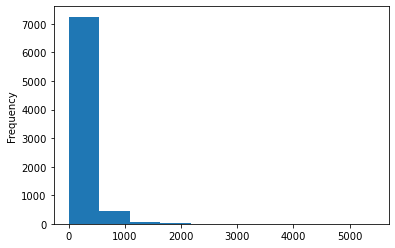

In [13]:
df['tokens'] = df.text.apply(lambda x: x.split())
df['num_tokens'] = df['tokens'].apply(len)
df['num_tokens'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

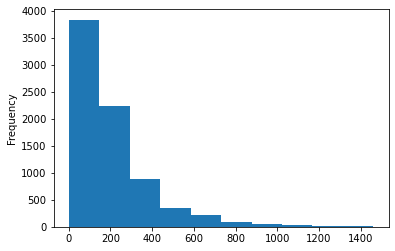

In [14]:
df = df[df['num_tokens'] < 1500]
df['num_tokens'].plot.hist()

In [15]:
df.shape

(7758, 4)

In [16]:
df['Product'].value_counts()

Debt collection                3228
Mortgage                       1574
Credit card or prepaid card    1284
Checking or savings account     866
Student loan                    512
Vehicle loan or lease           294
Name: Product, dtype: int64

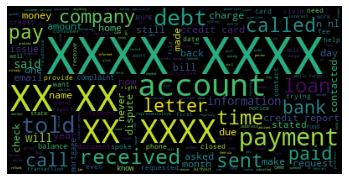

In [17]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

text = list(df[:10000].text.values)

wordcloud = WordCloud(stopwords=STOPWORDS).generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [27]:
df['target'] = df['Product'].map(target)

## Baseline

In [97]:
from tqdm import tqdm
tqdm.pandas()

class TextPreprocessing:
    def __init__(self, w2v=True):
        self.stop_words = stopwords.words('english')
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
    
    def _text_cleaning(self, text):
        
        # replace XX pattern
        regex = re.compile(r'[X]{2,}', re.S)
        text = regex.sub(lambda m: m.group().replace('X',"1"), text)
        
        text = text.lower()

        # Remove all the special characters
        clean_text = re.sub(r'[^A-Za-z$]+', ' ', text)

        # remove all single characters
        clean_text = re.sub(r'\b[a-zA-Z]\b', '', clean_text)

        # Remove single characters from the start
        clean_text = re.sub(r'\^[a-zA-Z]\b', ' ', clean_text)

        # Substituting multiple spaces with single space
        clean_text = re.sub(r'\s+', ' ', clean_text, flags=re.I)
        
        return clean_text
        
    def _tokenization(self, text):

        tokens = nltk.word_tokenize(text)

        # Remove stopwords

        tokens = [word for word in tokens if not word in self.stop_words]
        
        # Stemming tokens
        tokens = [self.stemmer.stem(token) for token in tokens]

        #Lemmatizing tokens
        tokens = [self.lemmatizer.lemmatize(token, pos='v') for token in tokens]

        return tokens

    def transform(self, df):
        
#         classifier = transformers.pipeline("zero-shot-classification", 
#                                            model="cross-encoder/nli-distilroberta-base", device='cpu')    
        
#         labels = df['Product'].drop_duplicates().tolist()

#         ds_df = df.reset_index(drop=True)[['text']].rename({"text": "sequences"}, axis='columns')
#         ds_df['sequences'] = ds_df['sequences'].apply(lambda x: x[:100])
#         ds = Dataset.from_pandas(ds_df)
#         scores = []
#         for out in tqdm(classifier(ds['sequences'], labels, batch_size=20)):
#             scores.append(out['scores'])
        
#         zcols = [f'zero_shot_{label}' for label in labels]    
#         zero_shot_df = pd.DataFrame(scores, columns=zcols)
#         df = pd.concat([df, zero_shot_df], axis='columns')
        
        df['clean_text'] = df['text'].progress_apply(self._text_cleaning)
        
        df['tokens'] = df['clean_text'].progress_apply(self._tokenization)
        
        df['tokenized_text'] = df['tokens'].progress_apply(lambda x: ' '.join(x))
        
        df['spacy_docs'] = df['text'].progress_apply(lambda x: nlp(x))
        df['w2v'] = df['spacy_docs'].progress_apply(lambda x: x.vector.reshape(1, -1)[0])
        
        for target in df['Product'].drop_duplicates():
            col_name = f'w2v_sim_{target}'
            target_doc = nlp(target)
            df[col_name] = df['spacy_docs'].progress_apply(lambda x: x.similarity(target_doc))
            
        for target in df['Product'].drop_duplicates():
            col_name = f'zero_shot_{target}'

        return df
        

In [98]:
from sklearn.feature_extraction.text import TfidfVectorizer

class FeatureExtraction(BaseEstimator, TransformerMixin):
    def __init__(self, args=None):
        self.vectorizer_tfidf = None
        self.args = args
        self.text_col = self.args['text_col']
        self.w2v_col = self.args['w2v_col']
            
    def fit(self, X, y = None):
        self.vectorizer_tfidf = TfidfVectorizer(**args['tfidf'])
        self.vectorizer_tfidf.fit(X[self.text_col])
    
    def transform(self, X, y = None):
        X = X.reset_index(drop=True)
        tfidf_vec = self.vectorizer_tfidf.transform(X[self.text_col])
        tfidf_df = pd.DataFrame(tfidf_vec.toarray(), columns=self.vectorizer_tfidf.get_feature_names())
        
        w2v_cols = [f'w2v_{i}' for i in list(range(X[self.w2v_col][0].shape[0]))]
        w2v_df = pd.DataFrame(X[self.w2v_col].tolist(), columns=w2v_cols)
        
        sim_cols = [c for c in X.columns if 'w2v_sim' in c]
        sim_df = X[sim_cols]
        
        zshot_cols = [c for c in X.columns if 'zero_shot' in c]
        zshot_df = X[zshot_cols]
        
        return pd.concat([tfidf_df, w2v_df, sim_df, zshot_df], axis=1)

    
    def fit_transform(self, X, y = None):
        X = X.reset_index(drop=True)
        self.fit(X)
        return self.transform(X)
        

In [ ]:
tp = TextPreprocessing()

df = tp.transform(df)
df.head()

In [299]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)

In [300]:
y_train = df_train.reset_index(drop=True)['target']
y_test = df_test.reset_index(drop=True)['target']

## HP Tuning

In [301]:
from sklearn.model_selection import cross_val_score
import numpy as np

def objective(trial):
    
    feature_args = {
        
        'ngram_range': trial.suggest_categorical('ngram_range', [(1, 1), (1, 2), (1, 3)]),
        'max_df': trial.suggest_loguniform('max_df', 0.7, 0.95),
        'min_df': trial.suggest_loguniform('min_df', 0.005, 0.05),
        'max_features': 500,
        'text_col': 'tokenized_text',
        'w2v_col': 'w2v'
    }
    
    xgb_params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }
    

    # Fit the model
    optuna_model = baseline_pipe = Pipeline(steps=[
        ('fe', FeatureExtraction(args=feature_args)),
        ('xgb', XGBClassifier(**xgb_params))
    ])

    # 4-fold CV score
    score = np.array(cross_val_score(optuna_model, 
                                     df_train, 
                                     y_train, 
                                     cv=4, 
                                     scoring='f1_macro')).mean()

    return score

In [304]:
study = optuna.create_study(direction='maximize')

[I 2022-11-13 17:02:31,844] A new study created in memory with name: no-name-54be5c9b-2ee3-4ae9-a61e-ce212b184936


In [305]:
study.optimize(objective, n_trials=10)

[I 2022-11-13 17:03:06,618] Trial 0 finished with value: 0.7815854483758435 and parameters: {'ngram_range': (1, 1), 'max_df': 0.704584636465177, 'min_df': 0.046581906458569466, 'max_depth': 5, 'learning_rate': 0.0424302098071921, 'n_estimators': 391, 'min_child_weight': 5, 'gamma': 0.0019594812313602815, 'subsample': 0.236054892064624, 'colsample_bytree': 0.08638755395598695, 'reg_alpha': 1.6887460935833313e-07, 'reg_lambda': 0.05530955368784443}. Best is trial 0 with value: 0.7815854483758435.
[I 2022-11-13 17:03:16,273] Trial 1 finished with value: 0.31672180586966026 and parameters: {'ngram_range': (1, 3), 'max_df': 0.8681091102577271, 'min_df': 0.03815389171212569, 'max_depth': 8, 'learning_rate': 0.0700273263497973, 'n_estimators': 213, 'min_child_weight': 3, 'gamma': 0.008680599190467124, 'subsample': 0.01407206007300339, 'colsample_bytree': 0.011003574063188632, 'reg_alpha': 1.0384784924418696e-06, 'reg_lambda': 0.494546713353236}. Best is trial 0 with value: 0.7815854483758435.

In [306]:
trial = study.best_trial
params = trial.params
params

{'ngram_range': (1, 1),
 'max_df': 0.704584636465177,
 'min_df': 0.046581906458569466,
 'max_depth': 5,
 'learning_rate': 0.0424302098071921,
 'n_estimators': 391,
 'min_child_weight': 5,
 'gamma': 0.0019594812313602815,
 'subsample': 0.236054892064624,
 'colsample_bytree': 0.08638755395598695,
 'reg_alpha': 1.6887460935833313e-07,
 'reg_lambda': 0.05530955368784443}

In [307]:
fe_param_list = ['ngram_range',
                   'max_df',
                   'min_df',
                   'max_features',
                ]

fe_params = {**{i: params[i] for i in params if i in fe_param_list}, 
             **{'text_col': 'tokenized_text', 'w2v_col': 'w2v'}}

xgb_params = {i: params[i] for i in params if i not in fe_param_list}

xgb_params

{'max_depth': 5,
 'learning_rate': 0.0424302098071921,
 'n_estimators': 391,
 'min_child_weight': 5,
 'gamma': 0.0019594812313602815,
 'subsample': 0.236054892064624,
 'colsample_bytree': 0.08638755395598695,
 'reg_alpha': 1.6887460935833313e-07,
 'reg_lambda': 0.05530955368784443}

## Evaluation

In [308]:
model = baseline_pipe = Pipeline(steps=[
        ('fe', FeatureExtraction(args=fe_params)),
        ('xgb', XGBClassifier(**xgb_params))
    ])

In [309]:
model.fit(df_train, y_train)

Pipeline(steps=[('fe',
                 FeatureExtraction(args={'max_df': 0.704584636465177,
                                         'min_df': 0.046581906458569466,
                                         'ngram_range': (1, 1),
                                         'text_col': 'tokenized_text',
                                         'w2v_col': 'w2v'})),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.08638755395598695,
                               early_stopping_rounds=None,
                               enable_ca...
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.0424302098071921, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
   

In [310]:
y_pred = model.predict(df_test)

In [311]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89       618
           1       0.81      0.74      0.78       281
           2       0.90      0.92      0.91       301
           3       0.84      0.78      0.81       188
           4       0.89      0.71      0.79        90
           5       0.90      0.38      0.54        68

    accuracy                           0.85      1546
   macro avg       0.86      0.75      0.78      1546
weighted avg       0.85      0.85      0.84      1546



<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

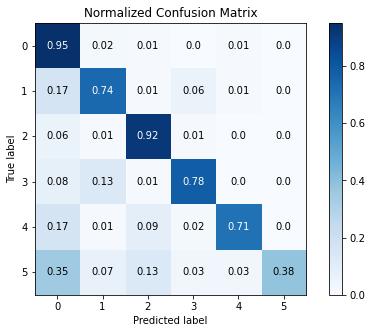

In [312]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8, 5))

In [234]:
df_train.head()

,text,Product,tokens,num_tokens,target,clean_text,tfidf_text,tokenized_text,w2v
277264,My name is XXXX XXXX and I started a reverse m...,Mortgage,"[name, start, revers, mortgag, applic, america...",415,2,my name is and started reverse mortgage applic...,name 1111 1111 start revers mortgag applic ame...,name start revers mortgag applic american advi...,"[-1.4595115, 0.71066505, -1.18247, -0.2951702,..."
478490,I have to credit agencies trying to collect on...,Debt collection,"[credit, agenc, tri, collect, old, medic, debt...",371,0,have to credit agencies trying to collect on ...,"credit agenc tri collect old medic debt , debt...",credit agenc tri collect old medic debt debt c...,"[-1.7610873, 0.4398927, -2.1569602, -0.1105511..."
566150,I purchased a XXXX XXXX XXXX XXXX XXXX purchas...,Vehicle loan or lease,"[purchas, purchas, date, purchas, person, beli...",470,5,purchased purchased from in on date of purcha...,purchas 1111 1111 1111 1111 1111 purchas 1111 ...,purchas purchas date purchas person believ sha...,"[-1.2383757, 0.9532511, -2.8963547, -1.0016904..."
815028,This company knowingly did business with a com...,Debt collection,"[compani, knowingli, busi, compani, break, law...",30,0,this company knowingly did business with compa...,compani knowingli busi compani break law viola...,compani knowingli busi compani break law viola...,"[-1.3742648, 0.2592088, -2.5936291, -0.6196591..."
418605,Company ( XXXX XXXX ) is reporting owed amount...,Debt collection,"[compani, report, owe, amount, $, report, debt...",176,0,company is reporting owed amounts of $ on my a...,compani ( 1111 1111 ) report owe amount { $ 30...,compani report owe amount $ report debt corp y...,"[-1.5181528, 0.70110196, -1.6604323, 0.0666893..."


In [238]:
df_train['w2v']

277264     [-1.4595115, 0.71066505, -1.18247, -0.2951702,...
478490     [-1.7610873, 0.4398927, -2.1569602, -0.1105511...
566150     [-1.2383757, 0.9532511, -2.8963547, -1.0016904...
815028     [-1.3742648, 0.2592088, -2.5936291, -0.6196591...
418605     [-1.5181528, 0.70110196, -1.6604323, 0.0666893...
                                 ...                        
678780     [-1.4173032, 0.55523705, -1.6393291, 0.1637128...
317336     [-1.5489014, 1.5139452, -2.2106924, 0.06308704...
5767       [-1.6668538, 0.35914618, -1.748455, -0.6533536...
1023593    [-1.6733052, 0.57663184, -1.0048169, -0.396895...
302172     [-2.4064152, -0.15424736, -2.3789678, -1.15609...
Name: w2v, Length: 6181, dtype: object

<AxesSubplot:>

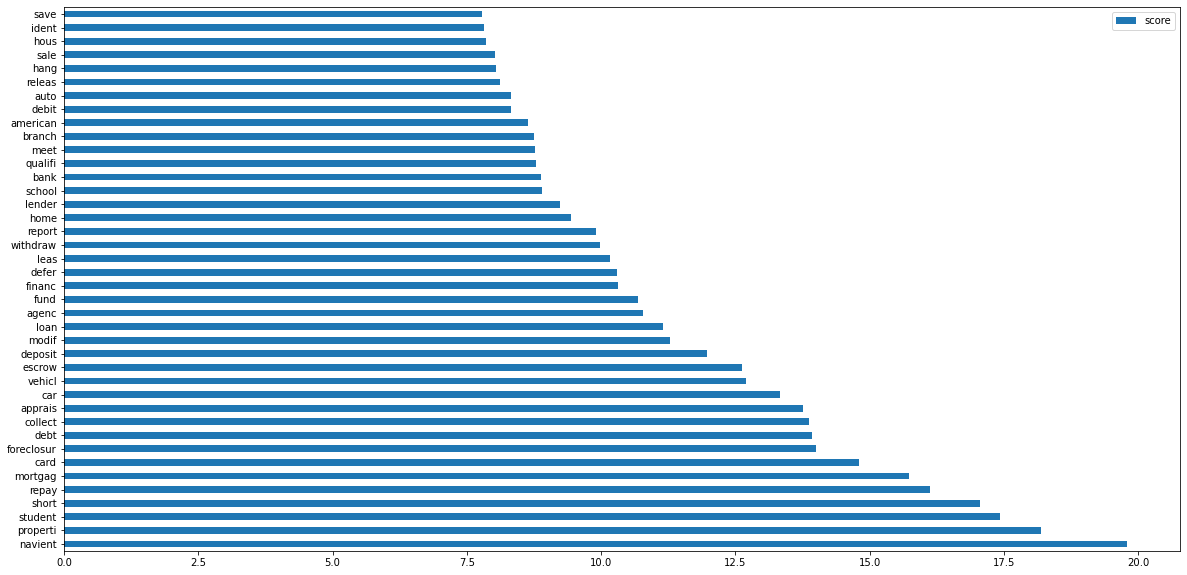

In [313]:
feature_important = model[1].get_booster().get_score(importance_type='gain')

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features